Before you turn in the homework, make sure everything runs as expected. To do so, select **Kernel**$\rightarrow$**Restart & Run All** in the toolbar above.  Remember to submit both on **DataHub** and **Gradescope**.

Please fill in your name and include a list of your collaborators below.

# Project 2: NYC Taxi Rides
# Extras

Put all of your extra work in here. Feel free to save figures to use when completing Part 4.

In [56]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
from sqlalchemy import create_engine
from utils import timeit

DATA SELECTION
Choosing the whole year data as training dataset

In [57]:
!ls -lh /srv/db/taxi_2016_student_small.sqlite

-rw-r--r-- 1 root root 2.1G Nov  7 04:44 /srv/db/taxi_2016_student_small.sqlite


In [58]:
DB_URI = "sqlite:////srv/db/taxi_2016_student_small.sqlite"
TABLE_NAME = "taxi"
sql_engine = create_engine(DB_URI)

In [59]:
q1d_query = f"""
            SELECT *
            FROM {TABLE_NAME}
            WHERE tpep_pickup_datetime
                BETWEEN '2016-01-01' AND '2016-07-01'
                AND record_id % 100 == 0
            ORDER BY tpep_pickup_datetime
            """

q1d_df = pd.read_sql_query(q1d_query, sql_engine)
data_16_df = pd.read_sql_query(q1d_query, sql_engine)
data_16_df['tpep_pickup_datetime'] = pd.to_datetime(data_16_df['tpep_pickup_datetime'])
data_16_df['tpep_dropoff_datetime'] = pd.to_datetime(data_16_df['tpep_dropoff_datetime'])
cleaned_data_16_df = data_16_df.copy()

In [60]:
q3a_query = f"""
            SELECT *
            FROM ({q1d_query})
            WHERE (julianday(tpep_dropoff_datetime)-julianday(tpep_pickup_datetime))
                BETWEEN 0 AND 0.5
            ORDER BY tpep_pickup_datetime
            """
q3a_df = pd.read_sql_query(q3a_query, sql_engine)
cleaned_data_16_df['duration'] = cleaned_data_16_df["tpep_dropoff_datetime"]-cleaned_data_16_df["tpep_pickup_datetime"]
cleaned_data_16_df['duration'] = cleaned_data_16_df['duration'].dt.total_seconds()
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['duration'] < 12 * 3600]

In [61]:
# Try using this function!
def bounding_condition(lat_l, lat_u, lon_l, lon_u):
    return f"""
            pickup_longitude <= {lon_u} AND
            pickup_longitude >= {lon_l} AND
            dropoff_longitude <= {lon_u} AND
            dropoff_longitude >= {lon_l} AND
            pickup_latitude <= {lat_u} AND
            pickup_latitude >= {lat_l} AND
            dropoff_latitude <= {lat_u} AND
            dropoff_latitude >= {lat_l} 
            """

lat_l = 40.63
lat_u = 40.85
lon_l = -74.03
lon_u = -73.75

In [62]:
q3b_query = f"""
        SELECT *
        FROM ({q3a_query})
        WHERE ({bounding_condition(lat_l, lat_u, lon_l, lon_u)})
        """

cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['pickup_longitude'] <= -73.75]
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['pickup_longitude'] >= -74.03]
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['pickup_latitude'] <= 40.85]
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['pickup_latitude'] >= 40.63]
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['dropoff_longitude'] <= -73.75]
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['dropoff_longitude'] >= -74.03]
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['dropoff_latitude'] <= 40.85]
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['dropoff_latitude'] >= 40.63]

In [63]:
q3c_query = f"""
        SELECT *
        FROM ({q3b_query})
        WHERE passenger_count>0
        """
q3c_df = pd.read_sql_query(q3c_query, sql_engine)
cleaned_data_16_df = cleaned_data_16_df[cleaned_data_16_df['passenger_count'] > 0]
#-rw-r--r-- 1 root root 2.1G Nov 27 07:32 /srv/db/taxi_2016_student_small.sqlite

In [64]:
num_records_removed = len(data_16_df)-len(cleaned_data_16_df)
proportion_records_removed = num_records_removed/len(data_16_df)
print(f'Records removed:{num_records_removed}')
print(f'Proportion records removed:{proportion_records_removed}')

Records removed:4593
Proportion records removed:0.03064962797370792


Training and Validation Split

In [69]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(cleaned_data_16_df, test_size=0.2, random_state=42)

In [70]:
Path("proj2B/data/part4").mkdir(parents=True, exist_ok=True)
data_file = Path("data/part4", "cleaned_data.hdf") # Path of hdf le
train_df.to_hdf(data_file, "train") # Train data of hdf le
val_df.to_hdf(data_file, "val") # Val data of hdf le

In [71]:
t_df = train_df.copy()

Caluating the mean and std

In [72]:
mean_df = t_df[['fare_amount','duration','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].groupby(t_df['tpep_pickup_datetime'].dt.date).mean()
std_df = t_df[['fare_amount','duration','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']].groupby(t_df['tpep_pickup_datetime'].dt.date).std()

mean_df = mean_df.rename(columns={'fare_amount':'fare_amount_mean','duration':'duration_mean','pickup_longitude':'pickup_longitude_mean','pickup_latitude':'pickup_latitude_mean','dropoff_longitude':'dropoff_longitude_mean','dropoff_latitude':'dropoff_latitude_mean'})
std_df = std_df.rename(columns={'fare_amount':'fare_amount_std','duration':'duration_std','pickup_longitude':'pickup_longitude_std','pickup_latitude':'pickup_latitude_std','dropoff_longitude':'dropoff_longitude_std','dropoff_latitude':'dropoff_latitude_std'})

t_df['date'] = t_df['tpep_pickup_datetime'].dt.date
mean_df = mean_df.rename(columns={'tpep_pickup_datetime':'date'})
std_df = std_df.rename(columns={'tpep_pickup_datetime':'date'})

In [73]:
merged_1 = pd.merge(t_df,mean_df,left_on='date',right_index=True,how='inner')
merged = pd.merge(merged_1,std_df,left_on='date',right_index=True,how='inner')

In [74]:
#Cleaned dataset
b1 = (merged['fare_amount']<=(2*merged['fare_amount_std']+merged['fare_amount_mean']))&\
    (merged['fare_amount']>=((-2)*merged['fare_amount_std']+merged['fare_amount_mean']))&\
    (merged['duration']<=(2*merged['duration_std']+merged['duration_mean']))&\
    (merged['duration']>=((-2)*merged['duration_std']+merged['duration_mean']))&\
    (merged['pickup_longitude']<=(2*merged['pickup_longitude_std']+merged['pickup_longitude_mean']))&\
    (merged['pickup_longitude']>=((-2)*merged['pickup_longitude_std']+merged['pickup_longitude_mean']))&\
    (merged['pickup_latitude']<=(2*merged['pickup_latitude_std']+merged['pickup_latitude_mean']))&\
    (merged['pickup_latitude']>=((-2)*merged['pickup_latitude_std']+merged['pickup_latitude_mean']))

In [75]:
tt_df = train_df[b1]
tt_df.head()

/srv/conda/envs/data100/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,record_id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,...,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
13903,6404500,1,2016-01-18 16:39:48,2016-01-18 16:49:43,1,4.80,-74.004501,40.707790,1,N,...,40.752083,2,15.5,0.0,0.5,0.00,0.0,0.3,16.30,595.0
121829,56477700,2,2016-05-26 14:41:54,2016-05-26 14:45:55,1,0.75,-73.974968,40.792801,1,N,...,40.783550,1,5.0,0.0,0.5,1.16,0.0,0.3,6.96,241.0
133961,60619000,2,2016-06-10 20:35:56,2016-06-10 20:43:07,1,0.85,-73.982674,40.756493,1,N,...,40.755337,2,6.5,0.5,0.5,0.00,0.0,0.3,7.80,431.0
45834,21948700,2,2016-02-27 12:22:30,2016-02-27 12:34:54,5,2.16,-73.990257,40.761864,1,N,...,40.739563,2,10.5,0.0,0.5,0.00,0.0,0.3,11.30,744.0
50933,23760800,1,2016-03-04 11:31:11,2016-03-04 11:52:53,1,1.60,-73.994308,40.751060,1,N,...,40.739605,1,14.0,0.0,0.5,3.00,0.0,0.3,17.80,1302.0


In [76]:
import os
import pandas as pd
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sqlalchemy import create_engine
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

sns.set(style="whitegrid", palette="muted")

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

%matplotlib inline

In [77]:
test_df = pd.read_csv("./proj2_test_data.csv")
test_df['tpep_pickup_datetime'] = pd.to_datetime(test_df['tpep_pickup_datetime'])
test_df.head()

,record_id,VendorID,tpep_pickup_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,10000,1,2016-01-02 01:45:37,1,1.20,-73.982224,40.768620,1,N,-73.983765,40.779598,1,6.0,0.5,0.5,2.00,0.0,0.3,9.30
1,19000,2,2016-01-02 03:05:16,1,10.90,-73.999977,40.738121,1,N,-73.888657,40.824364,1,31.5,0.5,0.5,6.56,0.0,0.3,39.36
2,21000,1,2016-01-02 03:24:36,1,1.80,-73.986618,40.747379,1,N,-73.978508,40.729622,1,8.5,0.5,0.5,1.96,0.0,0.3,11.76
3,23000,2,2016-01-02 03:47:38,1,5.95,-74.002922,40.744572,1,N,-73.942413,40.786419,1,20.5,0.5,0.5,4.36,0.0,0.3,26.16
4,27000,1,2016-01-02 04:36:44,1,1.60,-73.986366,40.759464,1,N,-73.963081,40.760353,2,8.0,0.5,0.5,0.00,0.0,0.3,9.30


In [78]:
# Copied from part 2
def haversine(lat1, lng1, lat2, lng2):
    """
    Compute haversine distance
    """
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    average_earth_radius = 6371
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * average_earth_radius * np.arcsin(np.sqrt(d))
    return h

# Copied from part 2
def manhattan_distance(lat1, lng1, lat2, lng2):
    """
    Compute Manhattan distance
    """
    a = haversine(lat1, lng1, lat1, lng2)
    b = haversine(lat1, lng1, lat2, lng1)
    return a + b

# Copied from part 2
def bearing(lat1, lng1, lat2, lng2):
    """
    Compute the bearing, or angle, from (lat1, lng1) to (lat2, lng2).
    A bearing of 0 refers to a NORTH orientation.
    """
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

# Copied from part 2
def add_time_columns(df):
    """
    Add temporal features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'month'] = df['tpep_pickup_datetime'].dt.month
    df.loc[:, 'week_of_year'] = df['tpep_pickup_datetime'].dt.weekofyear
    df.loc[:, 'day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df.loc[:, 'day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df.loc[:, 'hour'] = df['tpep_pickup_datetime'].dt.hour
    df.loc[:, 'week_hour'] = df['tpep_pickup_datetime'].dt.weekday * 24 + df['hour']
    return df

# Copied from part 2
def add_distance_columns(df):
    """
    Add distance features to df
    """
    df.is_copy = False # propogate write to original dataframe
    df.loc[:, 'manhattan'] = manhattan_distance(lat1=df['pickup_latitude'],
                                                lng1=df['pickup_longitude'],
                                                lat2=df['dropoff_latitude'],
                                                lng2=df['dropoff_longitude'])

    df.loc[:, 'bearing'] = bearing(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    df.loc[:, 'haversine'] = haversine(lat1=df['pickup_latitude'],
                                   lng1=df['pickup_longitude'],
                                   lat2=df['dropoff_latitude'],
                                   lng2=df['dropoff_longitude'])
    return df

def select_columns(data, *columns):
    return data.loc[:, columns]

In [79]:
def process_data_gm(data, test=False):
    X = (
        data
        
        # Transform data
        .pipe(add_time_columns)
        .pipe(add_distance_columns)
        
        .pipe(select_columns,        
              'pickup_longitude',  
              'pickup_latitude',   
              'dropoff_longitude', 
              'dropoff_latitude',
              'manhattan',
              'fare_amount'
             )
    )
    if test:
        y = None
    else:
        y = data['duration']
        
    return X, y

In [80]:
# Train
X_train, y_train = process_data_gm(tt_df)
X_val, y_val = process_data_gm(val_df)
final_model = lm.LinearRegression(fit_intercept=True)
final_model.fit(X_train, y_train)

# Predict
y_train_pred = final_model.predict(X_train)
y_val_pred = final_model.predict(X_val)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [81]:
X_train.iloc[0, :].dot(final_model.coef_) + final_model.intercept_

962.55629211460473

In [82]:
y_train_pred[0]

962.55629211463383

In [83]:
def mae(actual, predicted):
    """
    Calculates MAE from actual and predicted values
    Input:
      actual (1D array-like): vector of actual values
      predicted (1D array-like): vector of predicted/fitted values
    Output:
      a float, the MAE
    """
    
    mae = np.mean(np.abs(actual - predicted))
    return mae

In [84]:
print("Validation Error: ", mae(y_val_pred, y_val))

Validation Error:  141.566538884


In [85]:
from datetime import datetime
def generate_submission(test, predictions, force=False):
    if force:
        if not os.path.isdir("submissions"):
            os.mkdir("submissions")
        submission_df = pd.DataFrame({
            "id": test_df.index.values, 
            "duration": predictions,
        },
            columns=['id', 'duration'])

        timestamp = datetime.isoformat(datetime.now()).split(".")[0]

        submission_df.to_csv(f'submissions/submission_{timestamp}.csv', index=False)

        print(f'Created a CSV file: submission_{timestamp}.csv')
        print('You may now upload this CSV file to Kaggle for scoring.')

In [86]:
X_test, _ = process_data_gm(test_df, True)

/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4388: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
/srv/conda/envs/data100/lib/python3.6/site-packages/pandas/core/generic.py:4389: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [87]:
submission_predictions = (final_model
                          .fit(X_train, y_train)
                          .predict(X_test))
submission_predictions = submission_predictions.astype(int)
submission_predictions[submission_predictions < 0] = 0
generate_submission(test_df, submission_predictions, True)

Created a CSV file: submission_2018-12-06T03:38:17.csv
You may now upload this CSV file to Kaggle for scoring.


PLOTS

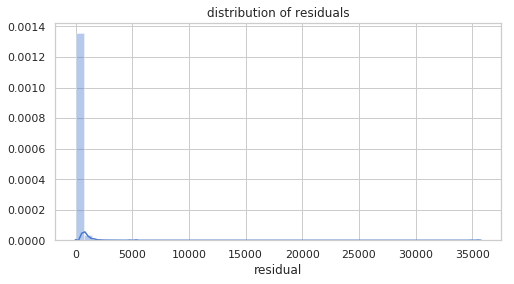

In [88]:
# Distribution of residuals
plt.figure(figsize=(8,4))
sns.distplot(np.abs(y_val - y_val_pred))
plt.xlabel('residual')
plt.title('distribution of residuals');

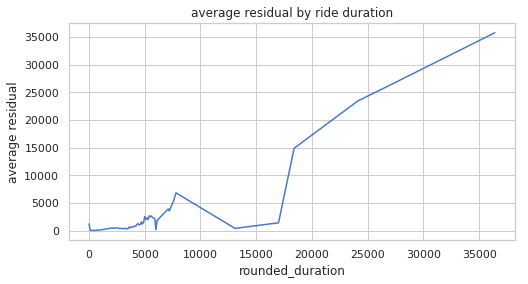

In [89]:
# Average residual grouping by ride duration
val_residual = X_val.copy()
val_residual['duration'] = y_val
val_residual['rounded_duration'] = np.around(y_val, -2)
val_residual['residual'] = np.abs(y_val - y_val_pred)
tmp = val_residual.groupby('rounded_duration').mean()
plt.figure(figsize=(8,4))
tmp['residual'].plot()
plt.ylabel('average residual')
plt.title('average residual by ride duration');

Text(0.5,0,'fare amount')

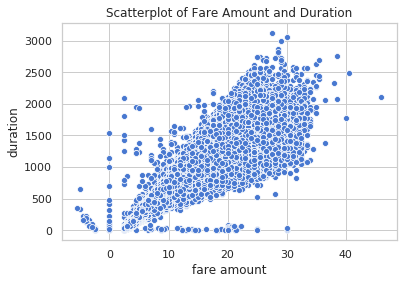

In [90]:
sns.scatterplot(x = tt_df['fare_amount'], y =tt_df['duration'])
plt.title('Scatterplot of Fare Amount and Duration')
plt.xlabel('fare amount')

## Submission

You're almost done!

Before submitting this assignment, ensure that you have:

1. Restarted the Kernel (in the menubar, select Kernel$\rightarrow$Restart & Run All)
2. Validated the notebook by clicking the "Validate" button.

Then,

1. **Submit** the assignment via the Assignments tab in **Datahub** 
1. **Upload and tag** the manually reviewed portions of the assignment on **Gradescope**